This notebook simulates an optimization algorithm for the shape of the optical pulse at the output of a fiber optical amplifier.

The fiber amplifier in this simulation is based on an Erbium-doped active fiber.

### Imports

In [33]:
from sharq.pulsed_erbium_amplifier.pedfa import pEDFA, load_erbium_xsections
from matplotlib import pyplot
from Iaji.SignalProcessing.Signals1D.pulses import Pulse
import numpy, scipy, sympy
from Iaji.SignalProcessing.Signals1D.correlator import correlator

### Notebook Options

In [34]:
%gui qt
%matplotlib widget

### Plotting Settings

In [35]:
axis_font = {"family": "Times New Roman", "size": 15}
title_font = {"family": "Times New Roman", "size": 20}
legend_font = {"family": "Times New Roman", "size": 13}

fonts = {"axis": axis_font, "title": title_font, "legend": legend_font}

### Useful Functions

In [36]:
def get_peak(x, y, relative_threshold:float=1e-5):
    sampling_period = x[1] - x[0]
    gradient = numpy.gradient(y)
    ##Detect peaks in the gradient
    ##--
    peak_indices = scipy.signal.find_peaks(numpy.abs(gradient), threshold=relative_threshold*numpy.min(numpy.abs(gradient)))[0]
    x = x.copy()[peak_indices[0]:peak_indices[-1]]
    y = y.copy()[peak_indices[0]:peak_indices[-1]]
    peak_x = numpy.array(peak_indices)*sampling_period
    return x, y, peak_x

In [37]:
#linear interpolation between the bottom of the pulse and the initial and final values of the peak.
def zero_pad_extend(x, y, x_extend, y_extend):
    sampling_period = x[1] - x[0]
    n_extend_2 = int(numpy.ceil(x_extend/2/sampling_period))
    x = numpy.concatenate((x[0] - numpy.flipud(numpy.arange(1, n_extend_2+1))*sampling_period, x, x[-1] + numpy.arange(1, n_extend_2+1)*sampling_period))
    y = numpy.concatenate((y_extend*numpy.ones((n_extend_2, )), y, y_extend*numpy.ones((n_extend_2, ))))
    return x, y

In [38]:
#Time alignment based on edge detection
def find_edges(x, y):
    sampling_period = x[1] - x[0]
    gradient = numpy.gradient(y)
    edge_indices = numpy.array([numpy.atleast_1d(numpy.argmax(gradient))[0], numpy.atleast_1d(numpy.argmin(gradient))[0]])
    x_edges = edge_indices*sampling_period
    return edge_indices, x_edges

def align(y1, y2, sampling_period):
    #Prepare equal length arrays
    n_min = numpy.min([y1.size, y2.size])
    y1_new = y1.copy()[:n_min]
    y2_new = y2.copy()[:n_min]
    x = numpy.linspace(0, (n_min-1)*sampling_period, n_min)
    #Find rising edges
    rising_index_y1, rising_index_y2 = (find_edges(x, y1_new)[0][0], find_edges(x, y2_new)[0][0])
    #Find delay
    delay = rising_index_y2 - rising_index_y1
    n_delay = int(numpy.abs(delay)) + 1
    if delay > 0: #y1 comes before y2 => delay y1
        #y1_new = numpy.concatenate((numpy.min(y1_new)*numpy.ones(n_delay,), y1_new))
        #y2_new = numpy.concatenate((y2_new, numpy.min(y2_new)*numpy.ones(n_delay+1,)))
        y2_new = y2_new[n_delay-1:]
        y1_new = y1_new[:-n_delay]
    else:
        #y2_new = numpy.concatenate((numpy.min(y2_new)*numpy.ones(n_delay,), y2_new))
        #y1_new = numpy.concatenate((y1_new, numpy.min(y1_new)*numpy.ones(n_delay,)))
        y1_new = y1_new[n_delay-1:]
        y2_new = y2_new[:-n_delay]
    x = numpy.concatenate((x, numpy.linspace(x[-1]+sampling_period, x[-1]+(n_delay-1)*sampling_period, n_delay))) 
    
    
    n_min = numpy.min([y1_new.size, y2_new.size])
    y1_new = y1_new[:n_min]
    y2_new = y2_new[:n_min]
    x = x[:n_min]
    return y1_new, y2_new, x

# Time Domain Parameters

In [39]:
dt = numpy.random.choice(numpy.linspace(0.1, 0.5, 100))*1e-9 #minimum time interval, to model "almost" continuous time [s]
print("Minimum time interval: %.2f ns"%(dt*1e9))
ts = 1e-9 #maximum sampling period of the experimental instruments (acquisition systems and signal generators)

Minimum time interval: 0.50 ns


# Representation of a Typical Pulse as a Polynomial

We seek to represent a pre-shaped pulse in the basis

\begin{equation}
    \mathcal{M} := \{t^n\}_{n=0}^{N-1} \qquad n \in \mathbb{N}, N \in \mathbb{N}_+, t \in \mathbb{R}
\end{equation}

where $n$ is the monomial order and $t$ represents time.

More directly, an arbitrary pulse $p(t)$ should be accurately represented as a polynomial,

\begin{equation}
    p(t) \simeq p_\mathcal{M}(t) := \sum\limits_{n=0}^{N-1} a_n t^n  \qquad a_n \in \mathbb{R}
\end{equation}

We wish to use the  minimum value of $N$ such that $p_\mathcal{M}(t)$ is ''close enough'' to $p(t)$ is some (functional) sense, for every pulse $p(t)$.

In [40]:
def pulse2polynomial(pulse:Pulse, order, sampling_period, only_peak=True):
    duration = pulse.stop-pulse.start
    time_extend = 0.2*duration
    time, pulse_sampled = pulse.sample(x1=pulse.start-time_extend/2, x2=pulse.stop+time_extend/2, fs=1/sampling_period)
    pulse_minimum = numpy.min(pulse_sampled)
    if only_peak:
        time, pulse_sampled, _ = get_peak(time, pulse_sampled)   
    poly_fit = numpy.polyfit(time, pulse_sampled, order-1)
    p = numpy.poly1d(poly_fit)
    if only_peak:
        time, p_array = zero_pad_extend(time, p(time), x_extend=ts, y_extend=pulse_minimum)
    else:
        time, p_array = (time, p(time))
    return time, p_array, p

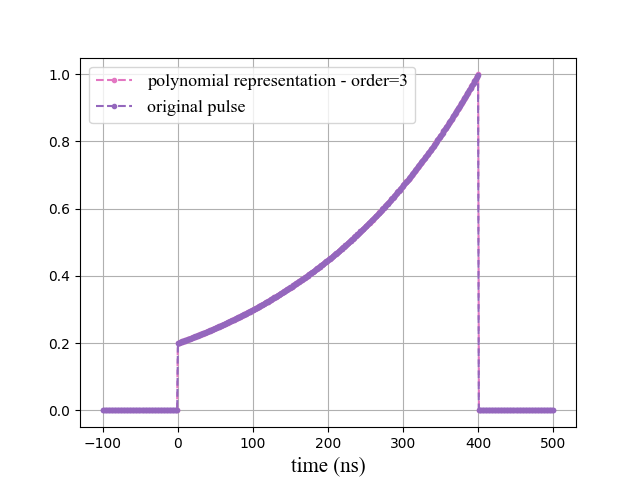

In [59]:
#Test for pulse2polynomial
p = Pulse()
p.symbolic.numeric_evaluation_module = "sympy"
p.set_shape_standard(start=0, stop=400e-9, window_type="rect", peak_type="exp",\
                     rise=20e-9, fall=40e-9, initial_level=0.2, final_level=1)
ts = 1e-9 #acquisition system's sampling period [s]
fs = numpy.ceil(1/ts*1e-9)*1e9
t_start, t_stop = (-100e-9, 500e-9)
fig = pyplot.figure()
axis = fig.add_subplot(111)
time, p_sampled = p.sample(t_start, t_stop, fs=fs)
poly_order = 3
time_poly, p_poly, polynomial = pulse2polynomial(p, order=5, sampling_period=ts)
axis.plot(time_poly*1e9, p_poly, linestyle="--", marker=".", color="tab:pink", label="polynomial representation - order=%d"%poly_order)
axis.plot(time*1e9, p_sampled, linestyle="--", marker=".", color="tab:purple", label="original pulse")
axis.set_xlabel("time (ns)", font=fonts["axis"])
axis.grid()
axis.legend(prop=fonts["legend"])

# Measures of Closeness Between Pulses

We need a (Lebesgue) measure to assess the quality of the pulse optimization procedure.

## $\mathcal{L}_2(\mathbb{R})$ Square-Distance

A natural measure of closeness between two square-integrable functions, such as the desired pulse $p_d(t)$ and the pulse measured at the output of the fiber amplified, say $p(t)$, is

\begin{equation}
    \left|\left|p_d(t) - p(t)\right|\right|^2_{\mathcal{L}_2(\mathbb{R})} := \int\limits_{\mathbb{R}} \left|p_d(t) - p(t)\right|^2 dt \simeq \int\limits_{\mathcal{D}_{max}} \left|p_d(t) - p(t)\right|^2 dt
\end{equation}

where $\mathcal{D}_{max}$ is the interval of maximum duration among the two pulses.

In [42]:
def L2_distance_squared(f1, f2, dx=1):
    return numpy.trapz(numpy.abs(f2-f1)**2, dx=dx)

def L2_distance_squared_normalized(f1, f2, dx=1):
    return L2_distance_squared(f1, f2, dx)/(numpy.sqrt(L2_distance_squared(f1, 0, dx)*L2_distance_squared(f2, 0, dx)))

def decorrelation(f1, f2, dx):
    corr = correlator(f1, f2, dx)
    corr.computeCorrelationCoefficient()
    return 1-corr.correlation_coefficient

In [43]:
#Test for L2_distance
x = numpy.linspace(0, 1, 100)
f1, f2 = (numpy.cos(x*numpy.pi), numpy.cos(x*numpy.pi+numpy.pi/4))
numpy.sqrt(L2_distance_squared(f1, f2, x[1]-x[0]))

0.5411961001461969

# Defining the Initial Input Fields

## Pump Field

In [44]:
input_pump_power = 3 #[W]

## Signal Field

In [45]:
input_peak_power = 200e-3 #[W]

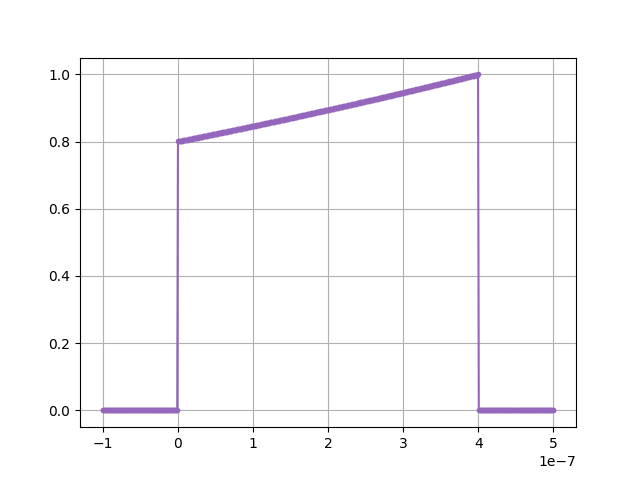

In [46]:
# Initial pulse shape
input_start = 0 #pulse start time [s]
input_stop = 400e-9 #pulse stop time [s]
input_rise = 10e-9
input_fall = input_rise

input_pulse = Pulse()
input_pulse.symbolic.numeric_evaluation_module = "sympy"
input_pulse.set_shape_standard(start=input_start, stop=input_stop, window_type="rect", peak_type="exp",\
                     rise=input_rise, fall=input_fall, initial_level=0.8, final_level=1)
axis_input_pulse = input_pulse.plot(input_start-100e-9, input_stop+100e-9, fs=numpy.ceil(1/ts*1e-9)*1e9)

# Defining the Measurement System

The photodetection system takes the output signal field pulse from the optical amplifier $p(t)$ and outputs a voltage of the type

\begin{equation}
    p(t) \longrightarrow A_{det} p(nT_s+T_{det}) + B_{det} + n_{det}(nT_s) \qquad n \in \mathbb{Z}
\end{equation}

where $T_s$ is the sampling period, $T_{det} \in \mathbb{R}_{o+}$ [s] is the time delay between the optical input and the output of the measurement system, $A_{det} \in \mathbb{R}$ [V/W] is a scale factor, $B_{det} \in \mathbb{R}$ [V] is the measurement offset and 

\begin{equation}
    n_{det}(t) \sim \mathcal{N}\left(0, \sigma^2_{det}\right)
\end{equation}

is the electronic noise of the measurement system, with zero mean and variance $\sigma^2_{det} \in \mathbb{R}_+$ [V].

To model jitter in the measurement time, we consider $T_{det}$ to have uniform probability distribution between 0 and a maximum delay $T_{det, max}$:

\begin{equation}
    T_{det} \sim \mathcal{U}\left(\left[-\frac{T_{det, max}}{2}, \frac{T_{det, max}}{2}\right]\right)
\end{equation}

In [47]:
def delay(x:numpy.ndarray, y:numpy.ndarray, x_delay:float):
    assert x.shape == y.shape
    dt = x[1] - x[0]
    x_new = x+x_delay
    indices = numpy.where(numpy.logical_and(x>=x_new[0], x<=x_new[-1]))
    y_new = y[indices]
    if x_delay < 0:
        x_new = x_new[0:y_new.size]
    else:
        x_new = x_new[int(numpy.ceil(x_delay/dt)):]
    return x_new, y_new
#-----------
class DetectionSystem:
    #--------------
    def __init__(self, A_det:float=1, B_det:float=0, sigma_det:float=0, T_det_max:float=0):
        self.A_det = A_det
        self.B_det = B_det
        self.sigma_det = sigma_det
        self.T_det_max = T_det_max
    #--------------
    def measure(self, input_time:numpy.ndarray, input_power:numpy.ndarray, ts:float):
        dt = input_time[1]-input_time[0]
        if dt >= ts:
            assert numpy.isclose(dt, ts)
            n_sampling = 1
        else:
            assert dt < ts
            n_sampling = int(ts/dt)
        #Sample the input signal
        time = input_time[::n_sampling]
        power = input_power[::n_sampling]
        #Randomly delay
        self.T_det = numpy.random.choice(numpy.linspace(-self.T_det_max/2, self.T_det_max/2, int(self.T_det_max/ts)))
        time, power = delay(time, power, self.T_det)
        #Apply Gaussian electronic noise
        n_det = numpy.random.normal(0, self.sigma_det, time.shape)
        return time, self.A_det*power + self.B_det + n_det

Detection delay: -29.6 ns


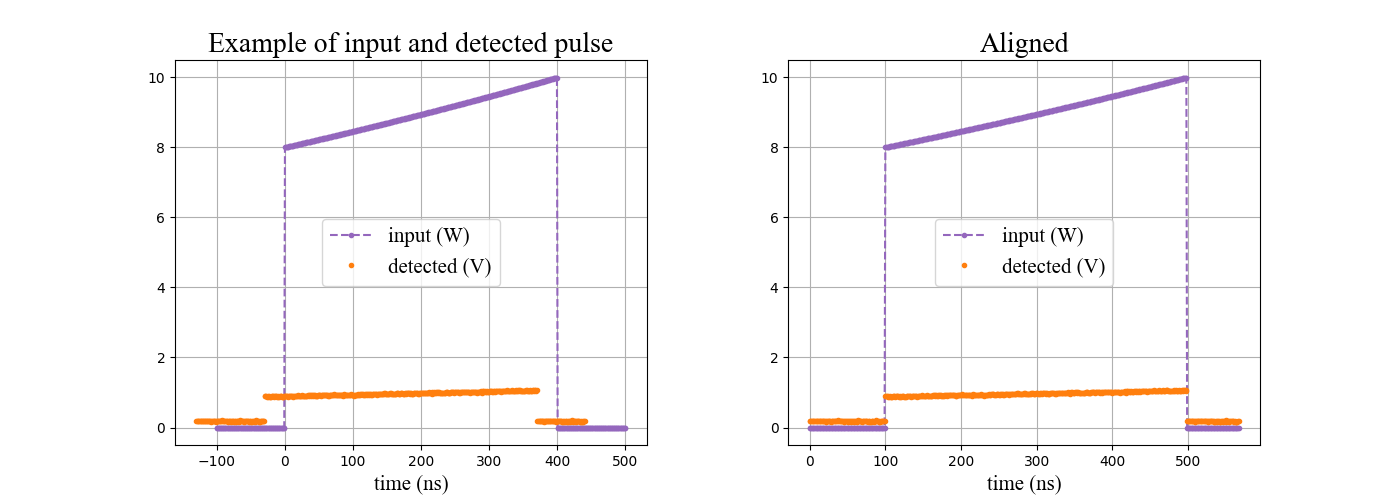

In [60]:
#Test for DetectionSystem
max_peak_power = 100 #[W]
B_det = 180e-3 #detector offset [V]
A_det = (9-B_det)/100

T_det_max = 100e-9 #maximum time delay of the measurement system [s]
sigma_det = 10e-3 #electronic noise standard deviation [V]

det = DetectionSystem(A_det, B_det, sigma_det, T_det_max)
#Create input pulse and detect
input_time_temp, input_pulse_array = input_pulse.sample(x1=-100e-9, x2=500e-9, fs=fs)
input_pulse_array *= 10
time_det, pulse_det = det.measure(input_time_temp, input_pulse_array, ts=ts)
#Align the input and detected pulses in time
input_pulse_array_corr, pulse_det_corr, time_corr = align(input_pulse_array, pulse_det, ts)
#Plot
fig = pyplot.figure(figsize=(14, 5))
fig.subplots_adjust(wspace=0.3)
ax = fig.add_subplot(1, 2, 1)
ax.set_title("Example of input and detected pulse", font=fonts["title"])
ax.set_xlabel("time (ns)", font=fonts["axis"])
ax.plot(input_time_temp*1e9, input_pulse_array, linestyle="--", marker=".", color="tab:purple", label="input (W)")
ax.plot(time_det*1e9, pulse_det, linestyle="None", marker=".", color="tab:orange", label="detected (V)")
print("Detection delay: %.1f ns"%(det.T_det*1e9))
ax.grid()
ax.legend(prop=fonts["axis"])
##Recorrelated axis
ax_corr = fig.add_subplot(1, 2, 2)
ax_corr.set_title("Aligned", font=fonts["title"])
ax_corr.set_xlabel("time (ns)", font=fonts["axis"])
ax_corr.plot(time_corr*1e9, input_pulse_array_corr, linestyle="--", marker=".", color="tab:purple", label="input (W)")
ax_corr.plot(time_corr*1e9, pulse_det_corr, linestyle="None", marker=".", color="tab:orange", label="detected (V)")
ax_corr.grid()
ax_corr.legend(prop=fonts["axis"])

# Defining the Fiber Optical Amplifier

## The Absorption and Emission Cross-sections of the Active Fiber

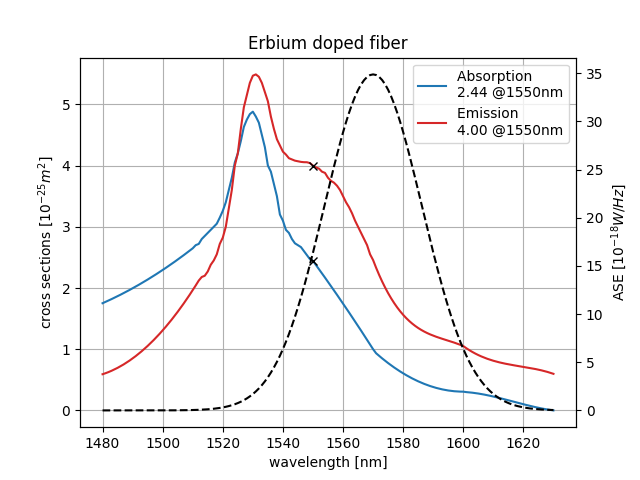

In [49]:
#Define the signal wavelength
lam_sig = 1550e-9
#Get examples of the wavelength-dependent absorption and emission cross-sections from experimental data
xsections_vals, xsections_specs = load_erbium_xsections(lam_sig)
wl = xsections_specs[0]
xabs = xsections_specs[1]
xemi = xsections_specs[2]
fig, ax = pyplot.subplots()
ax.plot(wl*1e9,xabs*1e25, 'C0', label = f'Absorption \n{xsections_vals[0]*1e25:.2f} @1550nm')
ax.plot(wl*1e9,xemi*1e25, 'C3', label = f'Emission \n{xsections_vals[1]*1e25:.2f} @1550nm')
ax.plot(lam_sig*1e9, xsections_vals[0]*1e25, 'kx')
ax.plot(lam_sig*1e9, xsections_vals[1]*1e25, 'kx')
axt = pyplot.twinx(ax)
axt.plot(wl*1e9, xsections_specs[3]*1e18, 'k--')
ax.set_title('Erbium doped fiber')
ax.set_xlabel('wavelength [nm]')
ax.set_ylabel(r'cross sections [$10^{-25} m^2$]')
ax.legend(loc=1)
axt.set_ylabel('ASE [$10^{-18} W/Hz$]')
ax.grid()

## Example of Amplifier Output

In [50]:
pedfa = pEDFA(sig_input=input_peak_power, pump_input=input_pump_power)
pedfa.set_xsection_vals(*xsections_vals)
pedfa.set_xsection_specs(*xsections_specs)
pedfa.define_fiber(L=0.25, R=3e-6, rho=6e25, N_fiber=200, N_padding=20)
pedfa.set_ASE(ASE=False)
pedfa.precalc(wait=1e-4, N=20)

In [51]:
pulse_time, input_pulse_array = input_pulse.sample(fs=1/dt)
pedfa.define_pulse(input_pulse_array*input_peak_power, dt)
pedfa.define_pump(pump_array=[])
pedfa.run_pulse()

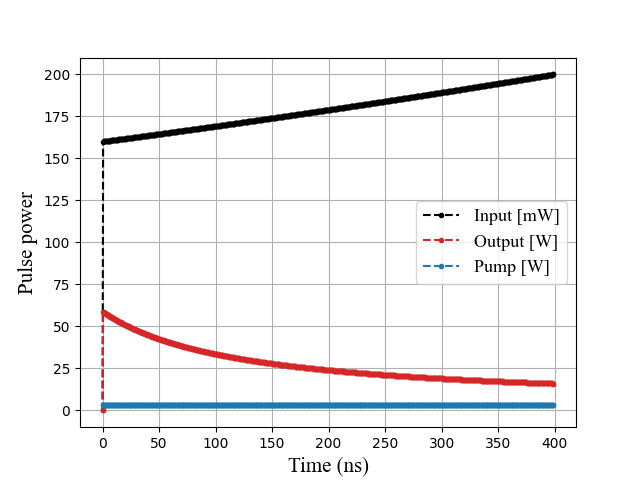

In [52]:
fig, ax = pyplot.subplots()
ax.plot(pedfa.pulse_time*1e9, pedfa.inputpulse*1e3, 'k', linestyle="--", marker=".", label='Input [mW]')
ax.plot(pedfa.pulse_time*1e9, pedfa.outputpulse, 'C3', linestyle="--", marker=".",label='Output [W]')
ax.plot(pedfa.pulse_time*1e9, pedfa.inputpump, 'C0', linestyle="--", marker=".",label='Pump [W]')
ax.set_xlabel('Time (ns)', font=fonts["axis"])
ax.set_ylabel('Pulse power', font=fonts["axis"], color='k')
ax.legend(prop=fonts["legend"])
ax.grid()

# Defining the Target Output Pulse

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


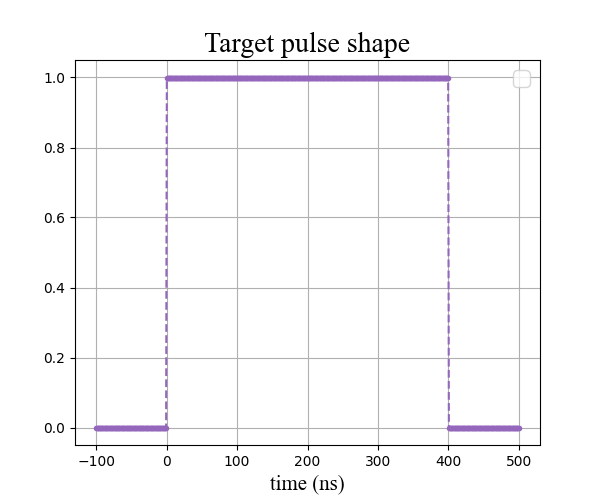

In [21]:
#Define the target output pulse
target_pulse = Pulse()
target_start = 0 #pulse start time [s]
target_stop = 400e-9 #pulse stop time [s]
target_rise, target_fall = (input_rise, input_fall)
##Define and sample pulse
target_pulse = Pulse()
target_pulse.symbolic.numeric_evaluation_module = "sympy"
target_pulse.set_shape_standard(start=target_start, stop=target_stop, window_type="rect", \
                                rise=target_rise, fall=target_fall, peak_type="exp", initial_level=1, final_level=1)
target_time, p_target = target_pulse.sample(x1=target_start-100e-9, x2=target_stop+100e-9, fs=fs)
##Plot pulse
fig = pyplot.figure(figsize=(6, 5))
ax_target = fig.add_subplot(111)
ax_target.set_title("Target pulse shape", font=fonts["title"])
ax_target.set_xlabel("time (ns)", font=fonts["axis"])
ax_target.plot(target_time*1e9, p_target, linestyle="--", marker=".", color="tab:purple")
ax_target.grid()
ax_target.legend(prop=fonts["axis"])

# Pulse Shape Optimization

In [22]:
from scipy.signal import resample
from scipy.optimize import minimize

def _normalize_pulse(p:numpy.ndarray):
    p_new = p.copy()
    p_new /= numpy.max(p_new)
    return p_new

def _normalize_pulse_L2(p:numpy.ndarray, dx:float=1):
    p_new = p.copy()
    return p_new/numpy.sqrt(L2_distance_squared(p_new, 0, dx))

def _run_pulse(amplifier:pEDFA, dt:float, input_pulse_array:numpy.ndarray, input_peak_power:float):
    amplifier.define_pulse(input_pulse_array.copy()*input_peak_power, dt)
    amplifier.define_pump(pump_array=[])
    amplifier.run_pulse()
    return zero_pad_extend(amplifier.pulse_time, amplifier.outputpulse, x_extend=100*dt, y_extend=numpy.min(amplifier.outputpulse))
    
def _measure_and_compute_cost(time:numpy.ndarray, p_out:numpy.ndarray, p_target:numpy.ndarray, ts:float):
    #Detect the pulse
    time_det, p_out_det = det.measure(time, p_out, ts)
    #Normalize the detected pulse
    p_out_det -= numpy.min(p_out_det)
    p_out_det = _normalize_pulse_L2(p_out_det, ts)
    p_target = _normalize_pulse_L2(p_target, ts)
    #Align the detected pulse with the target pulse in time
    p_out_det_corr, p_target_corr, time_det_corr = align(p_out_det, p_target, ts)
    #Compute the cost
    cost = L2_distance_squared(p_target_corr, p_out_det_corr, ts)
    return cost, time_det_corr, p_out_det_corr/numpy.max(p_out_det_corr), p_target_corr/numpy.max(p_target_corr)

def _run_pulse_and_compute_cost_multi_output(polynomial_coefficients:numpy.ndarray, \
                                             input_time:numpy.ndarray, input_peak_power:float,\
                         p_target:numpy.ndarray, amplifier:pEDFA, dt:float, ts:float, n_average:int=1, figure_axes=None):    
    #Prepare input pulse
    p_in = _normalize_pulse(numpy.abs(numpy.poly1d(polynomial_coefficients)(input_time)))
    input_time, p_in = zero_pad_extend(input_time, p_in, x_extend=100*ts, y_extend=0)
    cost = 0
    for n in range(n_avg):
        #Run the pulse thorugh the amplifier and compute cost function
        output_time, p_out = _run_pulse(amplifier, dt, p_in.copy(), input_peak_power)
        output = _measure_and_compute_cost(output_time.copy(), p_out.copy(), p_target.copy(), ts)
        cost += output[0]
    cost /= n_avg
    if figure_axes is not None:
        time_det_corr, p_out_det_corr, p_target_corr = output[1:]
        figure_axes["normalized pulses"].plot(input_time*1e9, p_in, linestyle="--", marker=".", color="tab:orange", label="input")
        figure_axes["normalized pulses"].plot(time_det_corr*1e9, p_target_corr, linestyle="--", marker=".", color="tab:green", label="target")
        figure_axes["normalized pulses"].plot(time_det_corr*1e9, p_out_det_corr, linestyle="--", marker=".", color="tab:purple", label="detected output")
        
        figure_axes["amplifier optical pulses"].plot(amplifier.pulse_time*1e9, amplifier.inputpulse*1e3, 'k', linestyle="--", marker=".", label='Input [mW]')
        figure_axes["amplifier optical pulses"].plot(amplifier.pulse_time*1e9, amplifier.outputpulse, 'C3', linestyle="--", marker=".",label='Output [W]')
        figure_axes["amplifier optical pulses"].plot(amplifier.pulse_time*1e9, amplifier.inputpump, 'C0', linestyle="--", marker=".",label='Pump [W]')
        
    return cost, *output[1:], input_time, p_in, polynomial_coefficients

def _run_pulse_and_compute_cost(polynomial_coefficients:numpy.ndarray, \
                                input_time:numpy.ndarray, input_peak_power:float,\
                         p_target:numpy.ndarray, amplifier:pEDFA, dt:float, ts:float, n_average:int=1, figure_axes=None):
    cost = _run_pulse_and_compute_cost_multi_output(polynomial_coefficients, input_time.copy(), input_peak_power,\
                         p_target.copy(), amplifier, dt, ts, n_average, figure_axes=figure_axes)[0]
    print(cost)
    return cost

# Gradient Descent Optimization of the Input Pulse Shape


We assume the input pulse to be described as a polynomial of chosen degree N, meaning that an input pulse $p_{in}(t)$ is described as 

\begin{equation}
    p_{in}(t) = \sum\limits_{n=0}^{N-1} a_n t^n  \qquad a_n \in \mathbb{R}
\end{equation}

Our aim is to optimize the shape of $p_{in}(t)$ to make the pulse at the amplifier output as close as possible to a target pulse $p^*(t)$.

The coefficient vector $\vec{a} := \left(a_0, ..., a_{N-1}\right) \in \mathbb{R}^N$ is the one that needs to be optimized.

We start from an initial guess $\vec{a}^{(0)} = \left(a^{(0)}_0, ..., a^{(0)}_N\right)$. At any given iteration $k\in \mathbb{N}$ of the algorithm, the following happens:

1. Given the coefficient vector $\vec{a}^{(k)}$, the pulse $p^{(k)}_{in}(t) = \sum\limits_{n=0}^{N-1} a^{(k)}_n t^n$ is input to the amplifier
2. The pulse output from the amplifier, $p^{(k)}_{out}(t)$, is measured via the photodetection system, yielding the voltage pulse $p^{(k)}_{out, det}(t)$
3. $p^{(k)}_{out, det}(t)$ is digitally normalized and aligned with $p^*(t)$ in time 
4. The cost function (e.g., the $\mathcal{L}_2(\mathbb{R})$ square-distance) is determined from $p^*(t)$ and $p^{(k)}_{out, det}(t)$, yelding $c^{(k)} = c\left(\vec{a}^{(k)}\right)$
5. The gradient of the cost function $c$ around the point $\vec{a}^{(k)}$ is determined, by translating each component of $\vec{a}^{(k)}$ by a step $\delta a$ in both positive and negative directions, and repeating steps 1-4 for each correspondingly generated pulse, to form the gradient $\vec{\nabla}\left(c^{(k)}\right)$
6. The next coefficient vector is chosen as $\vec{a}^{(k+1)} = \vec{a}^{(k)} - \eta \vec{\nabla}\left(c^{(k)}\right)$, where $\eta$ is the convergence rate

## Gradient Approximation by Finite Differences

### First-order Finite Differences

Given a sequence $c(\vec{a})$ and a minimum step $\delta a$, the gradient of $c$ at the point $\vec{a}$ can be approximated by

\begin{equation}
    \vec{\nabla}\left(c(\vec{a})\right) \simeq \frac{1}{2\delta a}\left(\left(\Delta c\right)_0, ..., \left(\Delta c\right)_{N-1}\right)
\end{equation}

where 

\begin{equation}
    \left(\Delta c\right)_n := c\left(\vec{a}+\delta a \vec{e}_n\right) - c\left(\vec{a}-\delta a \vec{e}_n\right)
\end{equation}

and $\vec{e}_n := (0_{0}, ..., 0_{n-1}, 1_{n}, 0_{n+1}, ..., 0_{N-1})$ is a canonical basis vector.


## Convergence Condition
The algorithm must stop once a certain condition, which should reflect the satisfactory quality of the output pulse at some iteration $k^*$, is met.

### Condition on the Value of the Cost Function
The algorithm may stop when $c^{(k^*)} < \epsilon_c$, where $\epsilon_c \in \mathbb{R}$ is chosen arbitrarily small.

### Condition on the Value of the Gradient
If the gradient of $c$ around the point $\vec{a}^{(k^*)}$ is lower than a certain value $\epsilon_\nabla$, i.e., $||\vec{\nabla}\left(c^{(k^*)}\right)|| < \epsilon_\nabla$, the algorithm is not progressing any significantly further, and the algorithm may stop.


# Pulse Shape Optimization Using scipy.optimize.minimize

# Pulse Shape Optimization Using scipy.optimize.least_squares

# Pulse Shape Optimization Using scipy.optimize.fmin_cg

# Pulse Shape Optimization with scipy.optimize.fminbound On each Pulse Representation Coefficient

In [30]:
from scipy.optimize import fminbound, minimize_scalar
def _optimize_pulse_shape_fminbound(target_pulse:Pulse, input_time:numpy.ndarray, initial_input_pulse:numpy.ndarray, input_peak_power:float, \
                                    polynomial_order:int, poly_coefficients_guess:numpy.ndarray, amplifier:pEDFA, dt:float, ts:float, max_iterations:int=None, n_average:int=1, plot:bool=False):
    #Target pulse array
    target_duration = target_pulse.stop - target_pulse.start
    target_time, p_target = target_pulse.sample(x1=target_pulse.start-0.2*target_duration, x2=target_pulse.stop+0.2*target_duration, fs=numpy.ceil(1/ts*1e-9)*1e9)
    p_in = initial_input_pulse
    #Plot option
    if plot:
        fig = pyplot.figure(figsize=(15, 6))
        fig.subplots_adjust(wspace=0.5)
        
        axes = {"normalized pulses": fig.add_subplot(1, 2, 1), "amplifier optical pulses": fig.add_subplot(1, 2, 2)}
        
        axes["normalized pulses"].set_title("Normalized pulses \n green: target pulse (a.u.) \n orange: input pulse (a.u.) \n purple: detected output pulse (a.u.)", font=fonts["axis"])
        axes["normalized pulses"].set_xlabel("time (ns)", font=fonts["axis"])
        axes["normalized pulses"].set_ylabel("value (a.u.)", font=fonts["axis"])
        axes["normalized pulses"].grid()
        
        axes["amplifier optical pulses"].set_title("Amplifier optical pulses \n black: amplifier input (mW) \n red: amplifier output (W) \n blue: pump input (W)", font=fonts["axis"])
        axes["amplifier optical pulses"].set_xlabel("time (ns)", font=fonts["axis"])
        axes["amplifier optical pulses"].set_ylabel("optical power", font=fonts["axis"])
        axes["amplifier optical pulses"].grid()
    else:
        axes = None
    #------------------
    def _run_and_compute_cost_1_component(coefficient, coefficient_index, all_coefficients,\
                                input_time, input_peak_power, p_target, amplifier, dt, ts, n_average, figure_axes):
        a = all_coefficients.copy()
        a[coefficient_index] = coefficient
        return _run_pulse_and_compute_cost(a, \
                                input_time.copy(), input_peak_power,\
                         p_target.copy(), amplifier, dt, ts, n_average, figure_axes)
    #---------------
    n_repeat = 1
    optimal_coefficients = numpy.zeros((N,n_repeat))
    base_x_factor = 2.8e1*input_peak_power/(3/2*100e-3) #the minimization bounds below were manually calibrated on an input peak power of 100 mW
    optimal_cost = numpy.inf*numpy.ones((n_repeat,))
    for k in range(n_repeat):
        optimal_coefficients[:, k] = poly_coefficients_guess.copy()
        orders = numpy.concatenate(([N-3, N-2, N-1], numpy.flipud(numpy.arange(N-3))))
        for j in orders:
        #orders = numpy.random.permutation(N)
        #print("orders: %s"%orders)
        #for j in orders:
            print("Optimizing the %d-th power coefficient\n-----------------"%(polynomial_order-1-j))
            if j == N-1:
                x1, x2 = (1e-9, 1)
            else: 
                x1, x2 = (optimal_coefficients[j, k]*(1-base_x_factor*10**k), optimal_coefficients[j, k]*(1+base_x_factor*10**k))
                x = [x1, x2]
                x.sort()
                x1, x2 = x
            #Optimize for the j-th component of the polynomial coefficient vector
            optimal_coefficients[j, k], optimal_cost[k], _, _ = fminbound(func=_run_and_compute_cost_1_component, x1=x1, x2=x2,\
                                                  args=(j, optimal_coefficients[:, k], input_time.copy(), input_peak_power, \
                             p_target, amplifier, dt, ts, n_average, axes), maxfun=500, full_output=True)

            '''
            result = minimize_scalar(fun=_run_and_compute_cost_1_component,\
                                                  args=(j, optimal_coefficients[:, k], input_time.copy(), input_peak_power, \
                             p_target.copy(), amplifier, dt, ts, n_average, axes), options={"maxiter": 100})
            optimal_coefficients[j, k], optimal_cost[k] = result.x, result.fun
            '''
    optimal_index = numpy.argmin(optimal_cost)
    print("optimal scaling index: %d"%optimal_index)
    return optimal_coefficients[:, optimal_index], input_time

Optimizing the 2-th power coefficient
-----------------
0.1886489733823356
0.09001550985083345
0.05233053003420786
0.036176913107877746
0.02865026589530879
0.024746802587790905
0.025203243040141817
0.024078822135289522
0.023705258650773612
0.02319929031911639
0.02295227990559392
0.022810564849135507
0.025347810842197758
0.02287523300253379
0.022656807478827104
0.02281069913923017
0.025353348026632624
0.022723967009221187
0.025510111782072277
0.02265287330943925
0.022794958036167504
0.02264944871990668
0.02278795566565647
0.025437013982519557
0.02541870738848956
0.022736826093987993
0.022704516684585344
0.022789284694760006
0.02266678722343305
0.02277389171808175
0.025436895599436102
0.022741483602515572
0.02262708101814603
0.022877160259445493
0.022719673555418783
0.022877124625945558
0.02286132539877655
0.02269268711469774
Optimizing the 1-th power coefficient
-----------------
0.457543844530685
0.008207516516377241
0.03159627885525006
0.018091170237389695
0.010649164006519392
0.00526

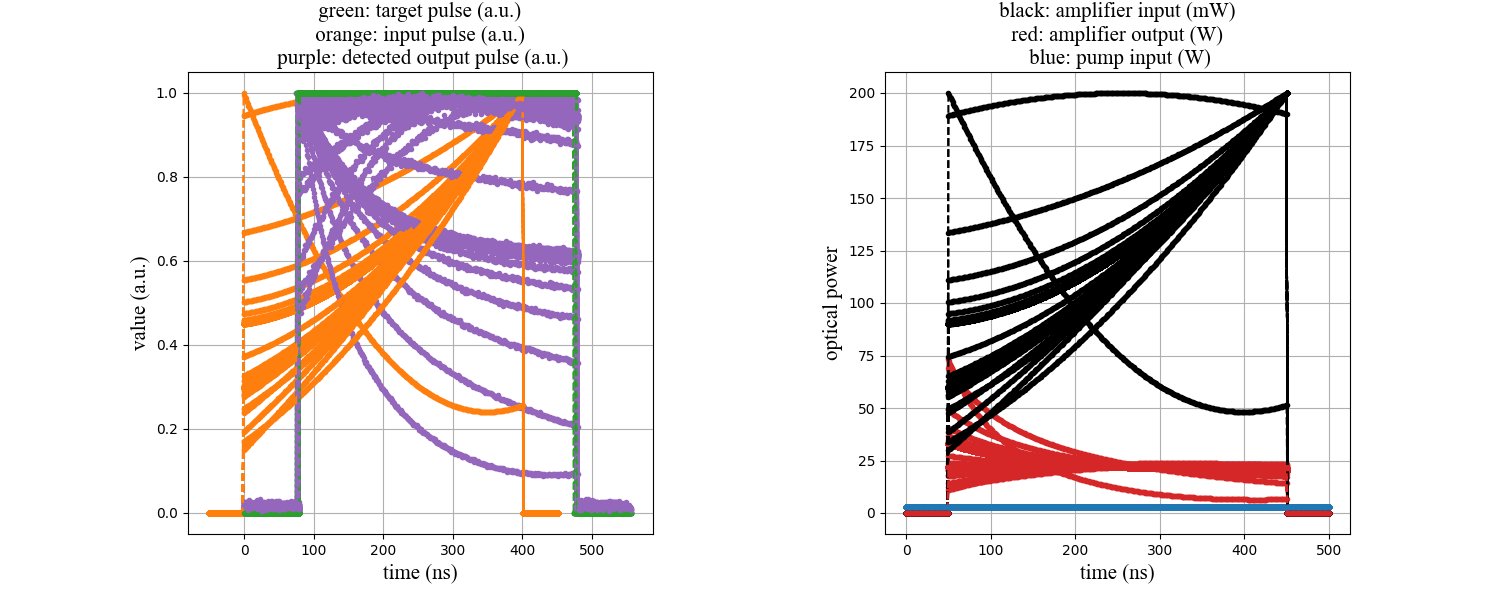

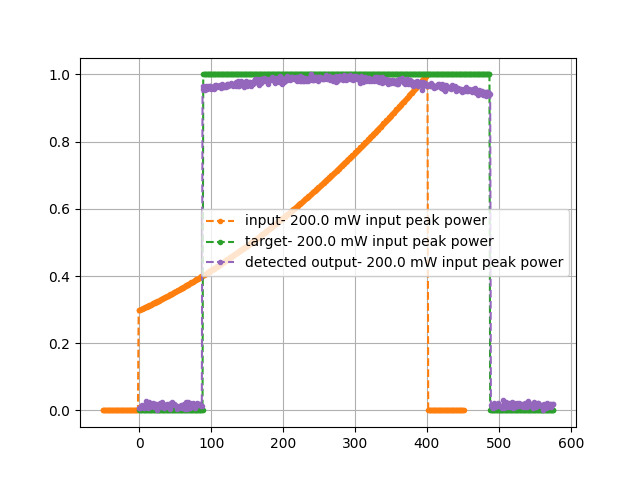

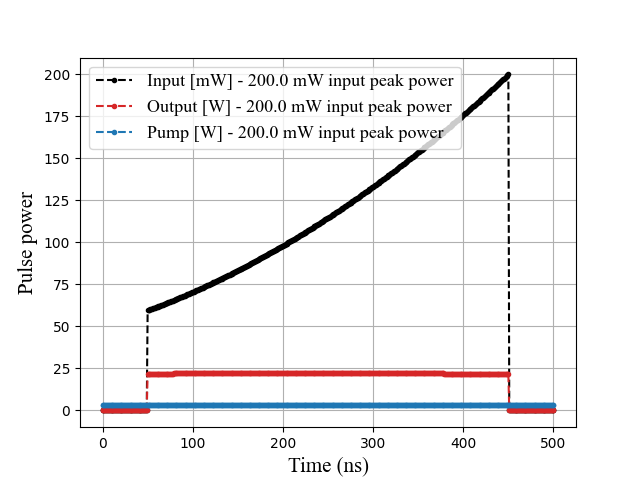

In [53]:
#Test example for scipy.optimize.fminbound
N = 3 #order of the polynomial, equal to the dimension of the coefficient vector
n_avg = 1
#Prepare the initial input pulse
input_time, p_in, a_opt = pulse2polynomial(pulse=input_pulse, order=N, sampling_period=ts)
a_opt = a_opt.coefficients
input_peak_powers = numpy.array([200])*1e-3
for j in range(input_peak_powers.size):
    #Optimize pulse shape
    input_peak_power = input_peak_powers[j]
    a_opt, input_time = _optimize_pulse_shape_fminbound(target_pulse=target_pulse, input_time=input_time.copy(), initial_input_pulse=p_in, poly_coefficients_guess=a_opt, \
                                                            input_peak_power=input_peak_power, \
                                        polynomial_order=N, amplifier=pedfa, dt=ts, ts=ts, n_average=n_avg, plot=True)
    #Plot the final normalized pulses
    #Target pulse array
    target_time, p_target = target_pulse.sample(x1=target_start-100*ts, x2=target_stop+100*ts, fs=numpy.ceil(1/ts*1e-9)*1e9)
    c, time_det_corr, p_out_det_corr, p_target_corr, input_time, p_in, a =  _run_pulse_and_compute_cost_multi_output(polynomial_coefficients=a_opt,\
                                                                                            input_time=input_time.copy(), input_peak_power=input_peak_power, \
                                                                                            p_target=p_target, amplifier=pedfa, dt=ts, ts=ts, n_average=n_avg)
    
    pyplot.figure()
    pyplot.plot(input_time*1e9, p_in, linestyle="--", marker=".", color="tab:orange", label="input- %.1f mW input peak power"%(input_peak_power*1e3))
    pyplot.plot(time_det_corr*1e9, p_target_corr, linestyle="--", marker=".", color="tab:green", label='target- %.1f mW input peak power'%(input_peak_power*1e3))
    pyplot.plot(time_det_corr*1e9, p_out_det_corr, linestyle="--", marker=".", color="tab:purple", label='detected output- %.1f mW input peak power'%(input_peak_power*1e3))
    pyplot.legend()
    pyplot.grid()
    #Run optimal pulse and plot the optical input and the output of the amplifier
    fig, ax = pyplot.subplots()
    ax.plot(pedfa.pulse_time*1e9, pedfa.inputpulse*1e3, 'k', linestyle="--", marker=".", label='Input [mW] - %.1f mW input peak power'%(input_peak_power*1e3))
    ax.plot(pedfa.pulse_time*1e9, pedfa.outputpulse, 'C3', linestyle="--", marker=".",label='Output [W] - %.1f mW input peak power'%(input_peak_power*1e3))
    ax.plot(pedfa.pulse_time*1e9, pedfa.inputpump, 'C0', linestyle="--", marker=".",label='Pump [W] - %.1f mW input peak power'%(input_peak_power*1e3))
    ax.set_xlabel('Time (ns)', font=fonts["axis"])
    ax.set_ylabel('Pulse power', font=fonts["axis"], color='k')
    ax.legend(prop=fonts["legend"])
    ax.grid()